*Copyright (c) 2023 Graphcore Ltd. All rights reserved.*

$$
\def\br{\mathbf{r}}
\def\bA{\mathbf{A}}
$$

# Integrals over Gaussian Type Orbitals (GTO)

We have a molecule comprising $M$ atoms (Mnemonic: $M$ for $\text{ato}M$),
each with atomic number $Z_m$ and position $\br_m \in \mathbb{R}^3$
$$
\mathcal{A} = \{ (Z_m, \br_m) \}_{m=1}^{M}
$$

We will represent the electron density of the molecule as a sum of per-atom electron densities.
$$
\psi(\br) = \sum_{m=1}^M \psi_m(\br)
$$
Atom $m$ has $I(Z_m)$ basis functions (determined by $Z_m$ and the basis set in use),
with coefficients $C = [c_{mi}]_{i=1}^{I(Z_m)}$:
$$
\psi_m(\br) = \sum_{i=1}^{I(Z_m)} c_{mi}~ \phi_{Z_m,i}(\br - \br_m)
$$
We can think of $C$ as a jagged array of coefficients, in terms of which the overall system is described by
$$
\psi(\br) = \sum_{m=1}^M \sum_{i=1}^{I(Z_m)} c_{mi} \phi_{Z_m,i}(\br - \br_m),
$$
and we can think of the task of DFT as being to determine the values $C$ which minimize
total energy.  That is: the task of DFT is to determine $\psi$, and here $\psi$ is 
specified by $C$, so the task is to determine $C$, for example by iteratively solving
Kohn-Sham equations using the self-consistent field (SCF) method.

<!-- See for example
> Lehtola, S., Blockhuys, F. and Van Alsenoy, C., 2020. An overview of self-consistent field calculations within finite basis sets. Molecules, 25(5), p.1218. [open access](https://doi.org/10.3390/molecules25051218) -->

Each function $\phi_{Z,i}$ is defined by the basis set as a fixed linear combination 
of primitive functions $p(\br; \nu)$, known as a "contraction":
$$
\forall_{i=1}^{I(Z)}: \phi_{Z,i}(\br) = \sum_{k=1}^{K(Z,i)} d_{Z,i,k} ~ p_{f(Z,i,k)}(\br; \nu_{Z,i,k})
$$
The values of $d,\nu$ and the function type $f$ are read from standard tables of basis sets.
In general the lengths $K(z,i)$ of the contractions have been pre-optimised alongside the contraction coefficients $d_{z,i,k}$ and the primitive exponents $\alpha_\mu$ to best approximate atomic orbitals.  A range of Gaussian basis sets covering the periodic table with different compute-time-vs-accuracy tradeoffs are available from the [basis set exchange](https://www.basissetexchange.org/).  We use their python API in this project to provide programmatic access to these basis sets.
As these functions $\phi$ are often taken as approximations of atomic orbitals, 
this is referred to as the linear combination of atomic orbitals (LCAO) method in the literature.

In this, we will consider only the function type "GTO", for Gaussian-type Orbital,
where the parameter packet $\nu$ comprises three non-negative integers $(l,m,n)$, 
called "angular momentum quantum numbers",
and a real value $\alpha$, the "exponent".
The primitive is
$$
\def\normp{N}
\def\pgto{p_{\text{GTO}}}
\pgto(\br; \nu) = \pgto(\br; l,m,n,\alpha) = \normp(l,m,n,\alpha) ~ x^l y^m z^n \exp(-\alpha\|\br\|^2)
$$
where the normalizing constant $\normp(l,m,n,\alpha)$ is a function of $\alpha$ and $(l, m, n)$
and is chosen so that the function integrates to 1, as derived later in this notebook.
In the following, as we are dealing only with GTO, we will simply write $p$ instead of $\pgto$.

Noting that a linear combination (LC) of LCs is just another LC, we will often 
contract the two sets of coefficients, writing
$$
\psi_m(\br) = \sum_{i=1}^{I(Z_m)} c_{mi} \sum_{k=1}^{K(z,i)} d_{Z_m,i,k} ~ p(\br - \br_m; \nu_{Z_m,i,k})
$$
as
$$
\psi_m(\br) = \sum_{j=1}^{I_m} a_{mj}~ p(\br - \br_m; \nu_{mj})
$$
where $I_m$ is just the total number of different $\nu$ values in the basis set for atom $Z_m$.
For most basis sets, this will mean $I_m = \sum_i K(Z_m,i)$.

### This notebook

This notebook derives several key computations involved in DFT.
In particular, DFT involves integrals of the form
$$
\def\op{\mathcal{Q}}
\langle\psi|\op|\psi\rangle = \int \int \psi(\br_1) ~\op \psi(\br_2) ~g(\br_1, \br_2) d \br_1 d \br_2
$$
where $\op\psi$ is a transformation of function $\psi$ by an operator $\op$, such as gradient $\nabla$, and the function $g$ is some function of a pair of points, e.g. $g(\mathbf r, \mathbf s) = \|\mathbf r - \mathbf s\|^{-1}$.
Such integrals can be written in terms of the per-atom (or "per-center") functions $\psi_m$
$$
\langle\psi|\op|\psi\rangle = \sum_{m_1=1}^M \sum_{m_2=1}^M \int \int \psi_{m_1}(\br_1) ~\op \psi_{m_2}(\br_2) ~g(\br_1, \br_2) d \br_1 d \br_2
$$
and then in terms of the primitives $p$, where again $\op p$ is the operator $\op$ applied to $p(\br;...)$.
$$
\langle\psi|Q|\psi\rangle = \sum_{m_1=1}^M \sum_{m_2=1}^M 
  \sum_{j_1=1}^{I_{m_1}} \sum_{j_2=1}^{I_{m_2}} 
   a_{m_1,j_1} a_{m_2,j_2} 
  \int \int p(\br_1 - \br_{m_1}; \nu_{m_1,j_1}) ~\op p(\br_2 - \br_{m_2}; \nu_{m_2,j_2}) ~ g(\br_1, \br_2) d \br_1 d \br_2
$$
all of which depends on the ability to compute integrals of the form
$$
\def\bB{\mathbf B}
\int \int p(\br_1 - \bA; \nu_A) ~\op p(\br_2 - \bB; \nu_B) ~g(\br_1, \br_2) ~d \br_1 d \br_2
$$
We will describe how to do so in the following, but first let's briefly look at the basis functions for a simple example.

## Basis set for a single-atom molecule

Before deriving the integrals, we use the `basisset` function to build the atomic orbitals of a single oxygen atom $M=1$, $Z_1 = 8$, illustraiting typical values for the numbers of orbitals and consequent numbers of primitives.
The `Basis` object built by `basisset` consists of a list of `Orbital` objects which are defined by a set of `coefficients` and corresponding `Primitive` objects.

A Basis set should define the following quantities:

For each atomic number $Z$, the number of basis functions, or "orbitals" is $I(Z)$.

For each basis function $i \in \{1..I(Z)\}$, the number of primitives is $K(Z, i)$.

In [16]:
import numpy as np
from pyscf_ipu.experimental.structure import Structure
from pyscf_ipu.experimental.basis import basisset

Z = 8
basisname = "sto-3g"
oxygen = Structure(atomic_number=np.array([Z]), position=np.zeros(3))
basis = basisset(oxygen, basisname)
print(f'The {basisname} basis for {Z=} has I(Z)={basis.num_orbitals}')

The sto-3g basis for Z=8 has I(Z)=5


The number of atomic orbitals follows from the [Aufbau principle](https://en.wikipedia.org/wiki/Aufbau_principle).  Applying this to a single Oxygen atom predicts the electron configuration as $1s^2 2s^2 2p^4$ which keeping in mind that the $2p$ atomic orbitals will consist of three orbitals we arrive at five atomic orbitals for a single oxygen atom.

This rule applies when using a minimal basis set such as `"sto-3g"` which uses a
contraction of 3 Gaussians to approximate each atomic orbital.  From this we expect a total of 15 primitives in the basis set for a single oxygen atom:

In [17]:
print(f'{basisname} for {Z=} has {len(basis.orbitals)} basis functions/orbitals')
for i,o in enumerate(basis.orbitals):
  terms = (f'{coef:.3f} * r**{p.lmn} * exp(-{p.alpha:.2f} r**2)' for coef,p in zip(o.coefficients,o.primitives))
  print(f'phi_({Z},{i})=', ' + '.join(terms))

# Now count unique prims
prims = set()
for o in basis.orbitals:
  for p in o.primitives:
    prims = set.union(prims, {(*p.lmn.tolist(), float(p.alpha))})
print(f'Found {len(prims)} unique primitives for {Z=} in {basisname}')

sto-3g for Z=8 has 5 basis functions/orbitals
phi_(8,0)= 0.154 * r**[0 0 0] * exp(-130.71 r**2) + 0.535 * r**[0 0 0] * exp(-23.81 r**2) + 0.445 * r**[0 0 0] * exp(-6.44 r**2)
phi_(8,1)= -0.100 * r**[0 0 0] * exp(-5.03 r**2) + 0.400 * r**[0 0 0] * exp(-1.17 r**2) + 0.700 * r**[0 0 0] * exp(-0.38 r**2)
phi_(8,2)= 0.156 * r**[1 0 0] * exp(-5.03 r**2) + 0.608 * r**[1 0 0] * exp(-1.17 r**2) + 0.392 * r**[1 0 0] * exp(-0.38 r**2)
phi_(8,3)= 0.156 * r**[0 1 0] * exp(-5.03 r**2) + 0.608 * r**[0 1 0] * exp(-1.17 r**2) + 0.392 * r**[0 1 0] * exp(-0.38 r**2)
phi_(8,4)= 0.156 * r**[0 0 1] * exp(-5.03 r**2) + 0.608 * r**[0 0 1] * exp(-1.17 r**2) + 0.392 * r**[0 0 1] * exp(-0.38 r**2)
Found 15 unique primitives for Z=8 in sto-3g


For a basis set such as `6-31+G` we have a different number of primitives in each basis function: 

In [18]:
basisname = "6-31+G"
oxygen = Structure(atomic_number=np.array([Z]), position=np.zeros(3))
basis = basisset(oxygen, basisname)
print(f'The {basisname} basis for {Z=} has I(Z)={basis.num_orbitals} basis functions/orbitals')

for i,o in enumerate(basis.orbitals):
  terms = (f'{coef:.3f} * r**{p.lmn} * exp(-{p.alpha:.2f} r**2)' for coef,p in zip(o.coefficients,o.primitives))
  print(f'phi_({Z},{i})=', ' + '.join(terms))

# Now count unique prims
prims = set()
for o in basis.orbitals:
  for p in o.primitives:
    prims = set.union(prims, {(*p.lmn.tolist(), float(p.alpha))})
print(f'Found {len(prims)} unique primitives for {Z=} in {basisname}')

The 6-31+G basis for Z=8 has I(Z)=13 basis functions/orbitals
phi_(8,0)= 0.002 * r**[0 0 0] * exp(-5484.67 r**2) + 0.014 * r**[0 0 0] * exp(-825.23 r**2) + 0.068 * r**[0 0 0] * exp(-188.05 r**2) + 0.233 * r**[0 0 0] * exp(-52.96 r**2) + 0.470 * r**[0 0 0] * exp(-16.90 r**2) + 0.359 * r**[0 0 0] * exp(-5.80 r**2)
phi_(8,1)= -0.111 * r**[0 0 0] * exp(-15.54 r**2) + -0.148 * r**[0 0 0] * exp(-3.60 r**2) + 1.131 * r**[0 0 0] * exp(-1.01 r**2)
phi_(8,2)= 1.000 * r**[0 0 0] * exp(-0.27 r**2)
phi_(8,3)= 1.000 * r**[0 0 0] * exp(-0.08 r**2)
phi_(8,4)= 0.071 * r**[1 0 0] * exp(-15.54 r**2) + 0.340 * r**[1 0 0] * exp(-3.60 r**2) + 0.727 * r**[1 0 0] * exp(-1.01 r**2)
phi_(8,5)= 0.071 * r**[0 1 0] * exp(-15.54 r**2) + 0.340 * r**[0 1 0] * exp(-3.60 r**2) + 0.727 * r**[0 1 0] * exp(-1.01 r**2)
phi_(8,6)= 0.071 * r**[0 0 1] * exp(-15.54 r**2) + 0.340 * r**[0 0 1] * exp(-3.60 r**2) + 0.727 * r**[0 0 1] * exp(-1.01 r**2)
phi_(8,7)= 1.000 * r**[1 0 0] * exp(-0.27 r**2)
phi_(8,8)= 1.000 * r**[0 1 0] * 

We can plot these atomic orbitals by first evaluating the basis functions on a regular grid and using py3DMol to render isosurfaces.  The $1s$ and $2s$ orbitals have spherical symmetry so we plot the $2px$ orbital below.

In [33]:
from pyscf_ipu.experimental.mesh import uniform_mesh, molecular_orbitals
from pyscf_ipu.experimental.plot import plot_volume


# Evaluate the molecular orbitals on a mesh -> [num_mesh_points, num_orbitals]
mesh, axes = uniform_mesh(n=32, b=3.0)
orbitals = molecular_orbitals(basis, mesh)
orbitals = np.asarray(orbitals)

# Mapping between orbital label -> index in basis set
# TODO: what is this mapping for 6-31+G?
#orbital_idx = dict(zip(["1s", "2s", "2px", "2py", "2pz"], range(5)))
plot_volume(oxygen, orbitals[:, 5], axes)
()

## Integrals over a single primitive

The GTO primitive
$$ 
p(\br; l,m,n,\alpha) = \normp(l,m,n,\alpha) ~ x^l y^m z^n e^{-\alpha\|\br\|^2}
$$
contains a normalization $\normp$, which should be chosen so that $p^2$ integrates to 1:
$$
\int p(\br; l,m,n,\alpha)^2 d\br = 1
$$
That is, 
$$
\normp(l,m,n,\alpha)^2 \int x^{2l} y^{2m} z^{2n} e^{-2\alpha\|\br\|^2} d\br = 1
$$
We note that $x^{2l} y^{2m} z^{2n} e^{-2\alpha\|\br\|^2}$ can be written
$$
\def\ldp{h} % Read this "1-D primitive"
\def\ldpi{H} % read this "1-D primitive's integral"
x^{2l} e^{-2\alpha x^2} \cdot
y^{2m} e^{-2\alpha y^2} \cdot
z^{2n} e^{-2\alpha z^2}
= 
\ldp(x;2l,2\alpha) ~ \ldp(y;2m,2\alpha) ~ \ldp(z;2n,2\alpha)
$$
for
$$
\tag{defh}
\ldp(t; 2k, \eta) = t^{2k} e^{-\eta t^2}
$$
So the integral
$$
\int x^{2l} y^{2m} z^{2n} \exp(-2\alpha\|\br\|^2) d\br = \int \ldp(x;2l,2\alpha) ~ \ldp(y;2m,2\alpha) ~ \ldp(z;2n,2\alpha) dx dy dz
$$
is the product of three independent integrals
$$
\int \ldp(x;2l,2\alpha) dx \cdot 
\int \ldp(y;2m,2\alpha) dy \cdot
\int \ldp(z;2n,2\alpha) dz
$$
Where each is of the form
$$
\tag{defH}
H(2k, \eta) = \int t^{2k} e^{-\eta t^2} dt
$$
These one dimensional integrals have a known analytic solution [see equation 42 of gaussian integral](https://mathworld.wolfram.com/GaussianIntegral.html), but we will lean on [SymPy](https://docs.sympy.org/latest/index.html) to help us derive a formula for normalising our primitive Gaussian functions.

First, let's define the integral:

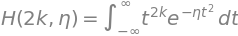

In [20]:
import numpy as np
import IPython
from sympy import *

init_printing(use_unicode=True)

eta = Symbol("eta", positive=True, real=True)
k = Symbol("k", integer=True, nonnegative=True)
t = Symbol("t", real=True)
H = Function("H")

H_na = Integral(t**(2*k) * exp(-eta * t**2), (t, -oo, oo))
display(Eq(H(2*k, eta), H_na))

Confirm that the equation displayed is the same as that in (defH).

And then solve it:

In [21]:
display(Eq(H(2*k, eta), H_na.doit().simplify()))

And, recalling that we are looking for the normalization $\normp(l,m,n,\alpha)$, which is given by
$$
\normp(l,m,n,\alpha) = \left(\int x^{2l} y^{2m} z^{2n} \exp(-2\alpha\|\br\|^2) d\br\right)^{-\frac12} = \biggl(H(2l,2\alpha)~H(2m,2\alpha)~H(2n,2\alpha)\biggr)^{-\frac12}
$$

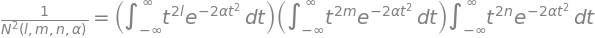

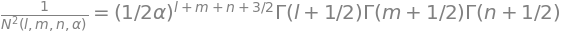

In [22]:
N = Function("N")
a = Symbol("alpha", positive=True, real=True)
l,m,n = symbols("l m n", integer=True, nonnegative=True)

H_l = H_na.subs({k:l, eta:2*a})
H_m = H_na.subs({k:m, eta:2*a})
H_n = H_na.subs({k:n, eta:2*a})

N_val = (H_l * H_m * H_n)
display(Eq(N(l,m,n,a)**(-2), N_val))
display(Eq(N(l,m,n,a)**(-2), N_val.doit().simplify()))

We might finally ask - what is $H$ for odd arguments?  And we can see: the integrand is odd, so it is zero.
And just in case, let's check: 

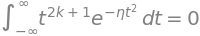

In [23]:
H_odd = Integral(t**(2*k + 1) * exp(-eta * t**2), (t, -oo, oo))
display(Eq(H_odd, H_odd.doit()))

We can use SymPy to generate a python function that uses the [gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html) function from scipy

In [24]:
f = lambdify((l,m,n, a), N_val.doit().simplify(), modules="scipy")
help(f)

Help on function _lambdifygenerated:

_lambdifygenerated(l, m, n, alpha)
    Created with lambdify. Signature:
    
    func(l, m, n, alpha)
    
    Expression:
    
    (1/(2*alpha))**(l + m + n + 3/2)*gamma(l + 1/2)*gamma(m + 1/2)*gamma(n + 1/2)
    
    Source code:
    
    def _lambdifygenerated(l, m, n, alpha):
        return ((1/2)/alpha)**(l + m + n + 3/2)*gamma(l + 1/2)*gamma(m + 1/2)*gamma(n + 1/2)
    
    
    Imported modules:



$$
\def\br{\mathbf{r}}
\def\bA{\mathbf{A}}
$$

## Integrals over sets of basis functions

The above visualisation uses the formulas defined earlier to numerically evaluate
each atomic orbital from a linear combintation of primitive Gaussians. Introducing
the basis set allows us to replace the problem of solving a system partial differential equations (e.g. the Kohn-Sham equations) with an algebraic system of equations that can be solved using standard matrix eigenvalue techniques.
The individual elements of the matrices in this system are single integrals over pairs of
primitives:
$$
\tag{5}
M_{AB} = \int p(\br - \bA; \nu_A) ~\op p(\br - \bB; \nu_B) d\br.
$$
The operator $\op$ in its most general definition is
a function that transforms the $\psi(\br)$ function to represent a physical observable.
That sounds fancy but is just a complicated way of saying we are breaking
down something we can measure (e.g. the energy, dipole moment, etc) into components
that we can evaluate through these integrals.  

## The overlap integral

The simplest operator $\op$ is simply an 
identity mapping, $\op p(\br) := p(\br)$, used in conjunction with the trivial $g(\br_1, \br_2) = 1$, that we name the _overlap integral_:
$$
\tag{6}
S_{\mu\nu} = \int p(\br - \br_\mu; l_\mu, m_\mu, n_\mu, \alpha_\mu) ~ p(\br - \br_\nu; l_\nu, m_\nu, n_\nu, \alpha_\nu) ~ d\br.
$$

Gaussian basis functions of the form above have a few convenient properties that help
make it easier to evaluate integrals of the form in equation (5).  To show this
we start by expanding the overlap integral into its full three-dimensional form:
$$
\tag{9}
\tilde{S}_{\mu \nu} = \iiint p_\mu(\br) p_\nu(\br) dx dy dz,
$$
and observing that a primitive $p_\mu(\br) = p(\br - \br_\mu; l_\mu, m_\mu, n_\mu, \alpha_\mu)$ can be written as a product of Cartesian components:
$$
\tag{10}
p_\mu(\br) = N_\mu
h(x - x_\mu; l_\mu, \alpha_\mu)
h(y - y_\mu; m_\mu, \alpha_\mu)
h(z - z_\mu; n_\mu, \alpha_\mu)
$$
where we are using $h$ from (defh), but not assuming that $l,m,n$ are even.
We directly see that we can separate the three-dimensional integral in equation (9) as a
product of three one-dimensional integrals:
$$
\tag{11}
\tilde{S}_{\mu \nu} = N_\mu N_\nu \tilde{S}_{\mu \nu}^{(x)} \tilde{S}_{\mu \nu}^{(y)} \tilde{S}_{\mu \nu}^{(z)}
$$
where we introduce the one-dimensional overlap as
$$
\tag{12}
\def\twelve{
\tilde{S}_{\mu \nu}^{(x)} = \int_{-\infty}^\infty 
\left((t - x_\mu)^{l_\mu} e^{-\alpha_\mu (t - x_\mu)^2} \right)
\left((t - x_\nu)^{l_\nu} e^{-\alpha_\nu (t - x_\nu)^2} \right) dt
}
\twelve,
$$
and use the same definition for the y and z components.  We note that if $\br_\mu=\br_\nu$, we have the normalization integral from (defH), because we can gather the $t - x_\mu$ terms
$$
\tilde{S}_{\mu \nu}^{(x)} = \int_{-\infty}^\infty 
(t - x_\mu)^{l_\mu + l\nu} e^{-(\alpha_\mu + \alpha_\nu) (t - x_\mu)^2} dt
$$
and substitite $u = t - x_\mu$, $du = dt$ to get
$$
\tilde{S}_{\mu \nu}^{(x)} = \int_{-\infty}^\infty 
u^{l_\mu + l\nu} e^{-(\alpha_\mu + \alpha_\nu) u^2} du = H(l_\mu + l_\nu, \alpha_\mu + \alpha_\nu)
$$
and in particular
$$
\tilde{S}_{\mu \mu}^{(x)} = \int_{-\infty}^\infty 
u^{2l_\mu} e^{-2\alpha_\mu u^2} du = H(2l_\mu, 2\alpha_\mu)
$$
as before.

### The hard case: non-coincident centres
Let us return our attention back to the general overlap elements in equation (12), 
repeated here: 
$$
(12) = \twelve
$$
but let's replace $\nu,\mu$ subscripts with more visually distinguishable symbols:
$$
\tilde{S}((A,\alpha,i), (B,\beta,j)) = \int_{-\infty}^\infty 
\left((t - A)^i e^{-\alpha (t - A)^2} \right)
\left((t - B)^j e^{-\beta (t - B)^2} \right) dt
$$
and grouping the polynomial terms and the Gaussian terms we get
$$
\tilde{S}((A,\alpha,i), (B,\beta,j))  = \int_{-\infty}^\infty 
\biggl((t - A)^i (t - B)^j \biggr)
\biggl( e^{-\alpha (t - A)^2}  e^{-\beta (t - B)^2} \biggr)
dt\\
$$
To make progress we start by rewriting the product of two
Gaussian functions as a single Gaussian:
$$
\tag{16}
e^{-\alpha (t - A)^2} e^{-\beta (t - B)^2} = 
G ~ e^{-\gamma (t - C)^2}, \\
\gamma = \alpha + \beta \\
C = \frac{\alpha A + \beta B}{\gamma}\\
G = \exp\left(-\frac{\alpha \beta}{\gamma} (A - B)^2\right) \\
$$
Next we rewrite the product of the leading polynomial terms in terms of the Gaussian product center $C$:
$$
\def\CA{C_A}
\def\CB{C_B}
\def\tc{t_C}
\tag{17}
(t - A)^i (t - B)^j = (t - C + C - A)^i (t - C + C - B)^j = (\tc + \CA)^i (\tc + \CB)^j,
$$
where we introduce
$$
\tag{18}
\tc = t - C\\
\CA = C - A\\
\CB = C - B.
$$
There isn't a universal term that covers the product of binomial expansions that we have arrived at in equation (17),
and using the [binomial theorem](https://en.wikipedia.org/wiki/Binomial_theorem) we have:
$$
\tag{19}
(\tc + \CA)^i = \sum_{k=0}^i \binom{i}{k} \tc^{i-k} \CA^k \\ 
(\tc + \CB)^j = \sum_{l=0}^j \binom{j}{l} \tc^{j-l} \CB^l 
$$

$$
\tag{20}
(\tc + \CA)^i (\tc + \CB)^j = \sum_{k=0}^i \sum_{l=0}^j \binom{i}{k} \binom{j}{l}  \tc^{i-k} \tc^{j-l} \CA^k \CB^l 
$$
we can use SymPy to help us take the product of these expansions for some representative values of $i$ and $j$

In [28]:
x, a, b = symbols("t, a, b", real=True)
i, j = symbols("i, j", nonnegative=True, integers=True)
poly_terms = (x + a)**i * (x + b) **j
poly_terms

In [29]:
from itertools import product


# output monomial terms with ascending orders x^n, n=0, 1, 2, ...
output = r"\begin{align*}"
for ival, jval in product(range(3), range(3)):
    p = simplify(expand(poly_terms.subs(i, ival).subs(j, jval)))
    output += f"(a + t)^{ival} (b + t)^{jval} &= "
    output += " + ".join(
        [latex(p.coeff(x, n) * x**n) for n in range(ival + jval + 1)]
    )
    output += r"\\"

output += r"\end{align*}"
IPython.display.Latex(output)

<IPython.core.display.Latex object>

By using the symmetry properties of the binomial expansion we can rewrite the terms in the series of Equation (20) as:
$$
\tag{21}
\binom{i}{k} \binom{j}{l}  \tc^{i-k} \tc^{j-l} \CA^k \CB^l  = \binom{i}{k} \binom{j}{l} \tc^k \tc^l \CA^{i-k} \CB^{j-l}.
$$
Recognising that we want to collect terms of same power $\tc^s$ we introduce the constraint that $k+l=s$ allows us to
write the terms as:
$$
\tag{22}
\binom{i}{s-l} \binom{j}{l} \tc^s \CA^{i-(s-l)} \CB^{j-l}.
$$
Replacing the summation variable $l=0, 1,\cdots, j$ with $t$ and incorporating the constraint we arrive at:
$$
\tag{23}
(\tc + \CA)^i (\tc + \CB)^j = 
\sum_{s = 0}^{i+j} \tc^s 
\sum_{\substack{t=0 \\ s - i \le t \le j}}^s 
\binom{i}{s-t} \binom{j}{t} \CA^{i-(s-t)} \CB^{j-t},
$$
Finally we can write this series as:
$$
\tag{24}
(\tc + \CA)^i (\tc + \CB)^j = \sum_{s = 0}^{i+j} B(i, j, \CA, \CB, s) \tc^s,
$$
where we introduce $B(i, j, \CA, \CB, s)$ as the coefficient of $x^s$ in the expansion:
$$
\tag{25}
B(i, j, \CA, \CB, s) = \sum_{\substack{t=0 \\ s - i \le t \le j}}^s \binom{i}{s-t} \binom{j}{t} \CA^{i - (s - t)} \CB^{j-t}
$$
An evaluation strategy for this variable-sized loop is explored in an accompanying [notebook](./binom_factor_table.ipynb).

Combining this result with the one we derived earlier for the product of two
Gaussian functions Equation 16 gives us:
$$
\tag{26}
\tilde{S}_{\mu \nu}^{(x)} = \int_{-\infty}^\infty 
\left((t - X_\mu)^{l_\mu} e^{-\alpha_\mu (t - X_\mu)^2} \right)
\left((t - X_\nu)^{l_\nu} e^{-\alpha_\nu (t - X_\nu)^2} \right) dt = \\
\int_{-\infty}^\infty 
 e^{-\alpha_\mu \alpha_\nu (X_\mu - X_\nu)^2 / \gamma} e^{-\gamma \tc^2}
\sum_{s=0}^{l_\mu+ l_\nu} B(l_\mu, l_\nu, C_\mu, C_\nu, s) \tc^s dt
$$
Swapping the order of integration and the summation we get
$$
 e^{-\alpha_\mu \alpha_\nu (X_\mu - X_\nu)^2 / \gamma} 
\sum_{s=0}^{l_\mu+ l_\nu} B(l_\mu, l_\nu, C_\mu, C_\nu, s) 
\int_{-\infty}^\infty \tc^s e^{-\gamma \tc^2} dt
$$
and see that we need to evaluate
integrals of the form that we already defined above at (Hdef)
$$
\tag{27}
H(s,\eta) = \int_{-\infty}^\infty t^s e^{-\eta t^2}  dt
$$

And we recall that for $s$ odd, this is zero, so we evaluate it only for $s$ even.

This result can also be written in terms of the [double factorial](https://en.wikipedia.org/wiki/Double_factorial#Additional_identities) which gives us two possible computation strategies for this integral:
$$
\tag{28}
H(2s, \eta) = \int_{-\infty}^{\infty} t^{2s} e^{-\eta t^2} dt \\
= \eta^{-s - \frac{1}{2}} \Gamma\left(s + \frac{1}{2}\right) \\
= \frac{(2s-1)!!}{(2\eta)^s} \sqrt{\frac{\pi}{\eta}}.
$$
The last form agrees with Equation (3.15) derived by [Fermann and Valeev](http://arxiv.org/abs/2007.12057).

Using the function $H(2s, \eta$ allows us to write the one-dimensional overlap integral as:
$$
\tag{29}
\tilde{S}_{\mu \nu}^{(x)} = 
e^{-\alpha_\mu \alpha_\nu (X_A - X_B)^2 / \gamma}
\sum_{s=0}^{\lfloor(l_\mu + l_\nu)/2 \rfloor} B(l_\mu, l_\nu, CA_x, CB_x, 2s)\;H(2s, \gamma)
$$
substituting this back into Equation (11) gives us the overlap of two primitive Gaussians:
$$
\tag{30}
\tilde{S}_{\mu \nu} = \iiint p_\mu(\br) p_\nu(\br) dx dy dz \\
= N_\mu N_\nu \exp\left(-\frac{\alpha_\mu \alpha_\nu |\mathbf{A}-\mathbf{B}|^2}{\alpha_\mu + \alpha_\nu}\right) \times\\
\sum_{s=0}^{\lfloor(l_\mu + l_\nu)/2 \rfloor} B(l_\mu, l_\nu, CA_x, CB_x, 2s)\;G(\gamma, 2s) \times \\
\sum_{s=0}^{\lfloor(m_\mu + m_\nu)/2 \rfloor} B(m_\mu, m_\nu, CA_y, CB_y, 2s)\;G(\gamma, 2s) \times \\
\sum_{s=0}^{\lfloor(n_\mu + n_\nu)/2 \rfloor} B(n_\mu, n_\nu, CA_z, CB_z, 2s)\;G(\gamma, 2s)
$$